In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os
train_file_path = "/content/drive/My Drive/StockData/final_validtest_set.csv"
test_file_path = "/content/drive/My Drive/StockData/final_test_set.csv"

if os.path.exists(test_file_path):
    test_df = pd.read_csv(test_file_path)
    print("Data loaded from CSV.")
if os.path.exists(train_file_path)    :
    train_df = pd.read_csv(train_file_path)
    print("Data loaded from CSV.")

Mounted at /content/drive
Data loaded from CSV.
Data loaded from CSV.


In [ ]:
cont_vars = ['Open', 'High', 'Low', 'Close', 'Adj Close','Volume', 'rsi','stochastic','signal-stochastic','cci', 'williams%R','roc','awesome-oscillator','ultimate-oscillator','trix','KAMA','stochrsi','sma','macd','ema','adx','psar-up','psar-down', 'ichimoku_a','ichimoku_b','supertrend','KST','plus_di','minus_di','VI-dff','VI+','VI-','atr','bb_bbm',
              'donchianwidth','keltnerwidth','ulcer','chaikin_volatility','historical_volatility','upper_band','lower_band'] # Remove 'Ticker' from cont_vars
seq_length = 20
forecast_horizon = 14
target_col = 'return_14d'
ticker_col = 'Ticker'
date_col = 'Date'
batch_size = 64  #

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib
from matplotlib.ticker import FuncFormatter # Import FuncFormatter
import yfinance as yf
import ta

def prepare_test_sequences(
    df,
    seq_length,
    forecast_horizon,
    cont_vars,
    target_col,
    ticker_col,
    date_col
):

    if not np.issubdtype(df[date_col].dtype, np.datetime64):
        df[date_col] = pd.to_datetime(df[date_col])

    df_sorted = df.sort_values([ticker_col, date_col]).reset_index()

    X_test = []
    y_test = []
    original_indices = []
    target_info_list = []

    tickers = df_sorted[ticker_col].unique()

    print(f"Preparing sequences for {len(tickers)} tickers...")

    for ticker in tickers:
        group = df_sorted[df_sorted[ticker_col] == ticker].reset_index(drop=True)

        n_rows = len(group)
        min_rows_needed = seq_length + forecast_horizon
        if n_rows < min_rows_needed:
            print(f"Ticker '{ticker}' skipped: not enough rows ({n_rows} < {min_rows_needed})")
            continue

        required_cols = cont_vars + [target_col, 'index']
        missing_cols = [col for col in required_cols if col not in group.columns]
        if missing_cols:
            print(f"Ticker '{ticker}' skipped: missing columns {missing_cols}")
            continue

        group = group.replace([np.inf, -np.inf], np.nan)


        features = group[cont_vars].to_numpy(dtype=np.float32)
        targets = group[target_col].to_numpy(dtype=np.float32)
        dates_arr = group[date_col].to_numpy()
        original_indices_arr = group['index'].to_numpy()

        max_start_idx = n_rows - seq_length - forecast_horizon + 1

        valid_seq_count = 0
        skipped_nan_target = 0
        skipped_nan_features = 0

        for start_idx in range(max_start_idx):
            seq_end_idx = start_idx + seq_length
            target_idx = seq_end_idx + forecast_horizon - 1

            if np.isnan(targets[target_idx]):
                skipped_nan_target += 1
                continue

            seq = features[start_idx:seq_end_idx].flatten()

            if np.isnan(seq).any():
                skipped_nan_features += 1
                continue

            X_test.append(seq)
            y_test.append(targets[target_idx])
            original_indices.append(original_indices_arr[target_idx])

            target_info_list.append({'Date': dates_arr[target_idx], 'Ticker': ticker, target_col: targets[target_idx]})

            valid_seq_count += 1

        print(
            f"Ticker '{ticker}': Generated {valid_seq_count} valid sequences, "
            f"skipped {skipped_nan_target} due to NaN targets, "
            f"skipped {skipped_nan_features} due to NaN features."
        )

    if len(X_test) == 0:
        print("Warning: No valid sequences generated in test set.")
        return np.array([]), np.array([]), pd.DataFrame(columns=['Date', 'Ticker', target_col]), np.array([])

    X_test = np.array(X_test)
    y_test = np.array(y_test, dtype=np.float32)
    original_indices = np.array(original_indices)
    target_info_df = pd.DataFrame(target_info_list)
    target_info_df['Date'] = pd.to_datetime(target_info_df['Date'])


    print(f"Total test sequences generated: {len(X_test)}")
    return X_test, y_test, target_info_df, original_indices

In [ ]:
cols_with_nans = ['psar-up', 'psar-down', 'KST']
for col in cols_with_nans:
    test_df[col] = test_df[col].fillna(method='ffill').fillna(0)
print(test_df[cont_vars].isna().sum())

Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
Volume                   0
rsi                      0
stochastic               0
signal-stochastic        0
cci                      0
williams%R               0
roc                      0
awesome-oscillator       0
ultimate-oscillator      0
trix                     0
KAMA                     0
stochrsi                 0
sma                      0
macd                     0
ema                      0
adx                      0
psar-up                  0
psar-down                0
ichimoku_a               0
ichimoku_b               0
supertrend               0
KST                      0
plus_di                  0
minus_di                 0
VI-dff                   0
VI+                      0
VI-                      0
atr                      0
bb_bbm                   0
donchianwidth            0
keltnerwidth             0
ulcer                    0
c

<ipython-input-38-fc980ef4cc6d>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df[col] = test_df[col].fillna(method='ffill').fillna(0)


Model loaded successfully from /content/drive/MyDrive/StockModels/xgb_best_model_randomsearch.joblib
Preparing sequences for 498 tickers...
Ticker 'A': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'AAPL': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ABBV': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ABNB': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ABT': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ACGL': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ACN': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ADBE': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
T

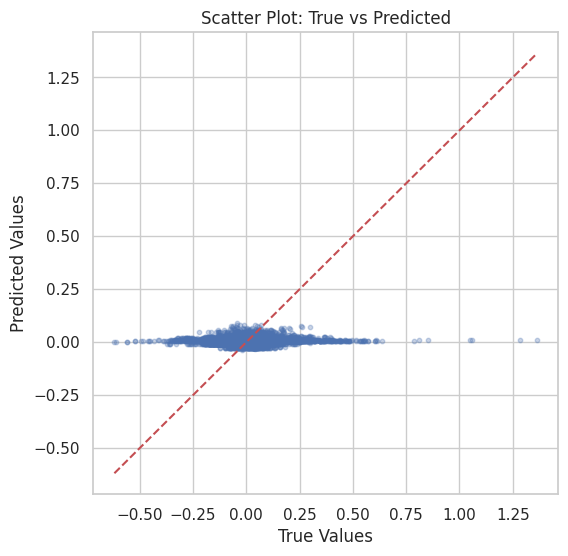

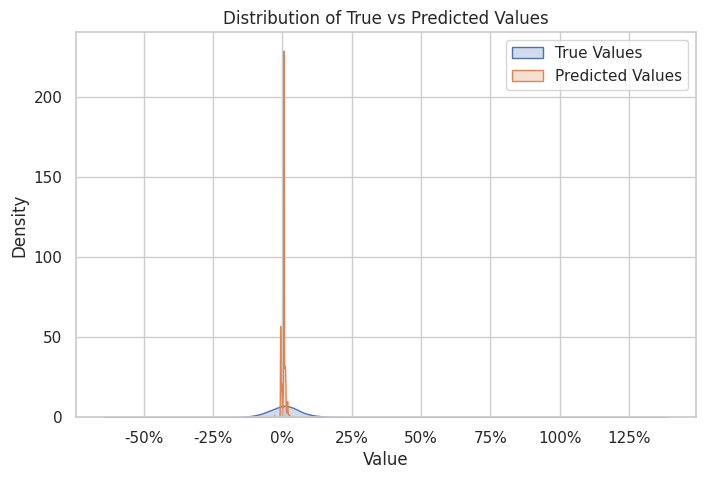

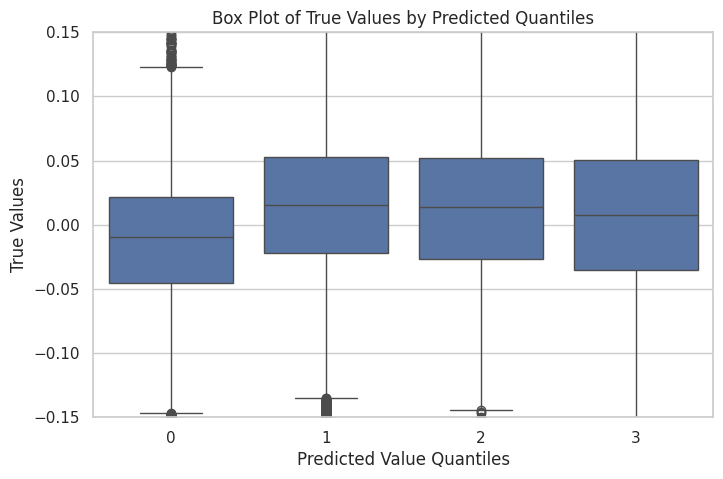

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from matplotlib.ticker import FuncFormatter

model_path = '/content/drive/MyDrive/StockModels/xgb_best_model_randomsearch.joblib'
try:
    best_model = joblib.load(model_path)
    print(f"Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model from {model_path}: {e}")
    best_model = None


if 'best_model' not in globals() or best_model is None:
    print("Error: XGBoost model ('best_model') not found or not trained. Please run the previous cells successfully.")
else:

    X_test, y_test, target_info_df,original_indices = prepare_test_sequences(
        test_df,
        seq_length=10,
        forecast_horizon=14,
        cont_vars=cont_vars,
        target_col=target_col,
        ticker_col=ticker_col,
        date_col=date_col,
    )

    print(f"Test data shape: {X_test.shape}, Test targets shape: {y_test.shape}")
    print(f"Target Info shape: {target_info_df.shape}")

    if len(X_test) == 0 or len(y_test) == 0 or target_info_df.empty:
        print("No test data sequences were generated. Cannot proceed with prediction and evaluation.")
    else:
        y_test_pred = best_model.predict(X_test)

        mae_test = mean_absolute_error(y_test, y_test_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        print(f"Test MAE: {mae_test:.4f}")
        print(f"Test MSE: {mse_test:.4f}")

        plot_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_test_pred})

        if 'clip_min' in globals() and 'clip_max' in globals():
             plot_df['y_true_clipped'] = plot_df['y_true'].clip(clip_min, clip_max)
             plot_df['y_pred_clipped'] = plot_df['y_pred'].clip(clip_min, clip_max)
             print("Clipped y_true and y_pred for plotting.")
             plot_y_true = plot_df['y_true_clipped']
             plot_y_pred = plot_df['y_pred_clipped']
        else:
             print("clip_min and clip_max not found. Plotting unclipped values.")
             plot_y_true = plot_df['y_true']
             plot_y_pred = plot_df['y_pred']



        plt.figure(figsize=(6,6))
        plt.scatter(plot_y_true, plot_y_pred, alpha=0.3, s=10)
        min_val = min(plot_y_true.min(), plot_y_pred.min())
        max_val = max(plot_y_true.max(), plot_y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title("Scatter Plot: True vs Predicted")
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(8,5))
        sns.kdeplot(plot_y_true, label='True Values', fill=True)
        sns.kdeplot(plot_y_pred, label='Predicted Values', fill=True)
        plt.title('Distribution of True vs Predicted Values')
        plt.xlabel('Value')
        plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
        plt.legend()
        plt.show()

        if len(np.unique(plot_df['y_pred'])) >= 5:
            try:
                quantiles = pd.qcut(plot_df['y_pred'], q=5, labels=False, duplicates='drop')
                boxplot_df = pd.DataFrame({'True': plot_y_true, 'PredictedQuantile': quantiles})

                plt.figure(figsize=(8,5))
                sns.boxplot(x='PredictedQuantile', y='True', data=boxplot_df)
                plt.xlabel("Predicted Value Quantiles")
                plt.ylabel("True Values")
                plt.title("Box Plot of True Values by Predicted Quantiles")
                plt.ylim(-0.15,0.15)
                plt.show()
            except Exception as e:
                 print(f"Error creating or plotting box plot by quantiles: {e}")
        else:
            print(f"Not enough unique predicted values ({len(np.unique(plot_df['y_pred'] ))}) to create 5 quantiles for box plot.")

In [ ]:
import numpy as np

# Create a copy of your DataFrame to avoid modifying the original data
df_baseline = test_df.copy()

# Generate buy signals based on RSI and Stochastic Oscillator
df_baseline['baseline_signal'] = np.where(
    (df_baseline['rsi'] < 30) & (df_baseline['stochastic'] < 20), 1, 0
)
# Calculate strategy returns: if signal is 1, take the return; else, return is 0
df_baseline['baseline_return'] = np.where(
    df_baseline['baseline_signal'] == 1, df_baseline['return_14d'], 0
)

# Optionally, clip extreme returns to avoid outliers
clip_min, clip_max = -0.5, 1.0  # Adjust as needed
df_baseline['baseline_return_clipped'] = df_baseline['baseline_return'].clip(clip_min, clip_max)

# Calculate mean return per 14-day period
baseline_mean_return = df_baseline['baseline_return_clipped'].mean()

# Calculate win rate: proportion of positive returns when signal is 1
win_rate = (
    df_baseline.loc[df_baseline['baseline_signal'] == 1, 'return_14d'] > 0
).mean()

print(f"Mean Baseline Return per 14-day period: {baseline_mean_return:.2%}")
print(f"Win Rate (Baseline Strategy): {win_rate:.2%}")


Mean Baseline Return per 14-day period: 0.05%
Win Rate (Baseline Strategy): 37.04%



--- Running Model Strategy Backtest ---


[*********************100%***********************]  1 of 1 completed

--- End of Backtest: Processing 101 remaining open positions ---
Total Capital Returned from Final Closeout: 10100.00
Total Profit/Loss from Final Closeout: -297.14
Final Portfolio Value after Closeout: 9813.70

--- Running Baseline Strategy Calculation ---
Baseline Strategy calculated for 100 dates.


--- Plotting Data Check (Filtered) ---
Filtered Strategy Returns Head:
Date
2024-07-22    0.0
2024-07-23    0.0
2024-07-24    0.0
2024-07-25    0.0
2024-07-26    0.0
dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 93 entries, 2024-07-22 to 2024-11-29
Series name: None
Non-Null Count  Dtype  
--------------  -----  
93 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB
Filtered Strategy Returns Info:
None
Number of finite Filtered Strategy Returns: 93 out of 93
Filtered Portfolio History Head:
Date
2024-07-22    10000.0
2024-07-23    10000.0
2024-07-24    10000.0
2024-07-25    10000.0
2024-07-26    10000.0
dtype: float64
<class 'pandas.core.series.Series'>
Date

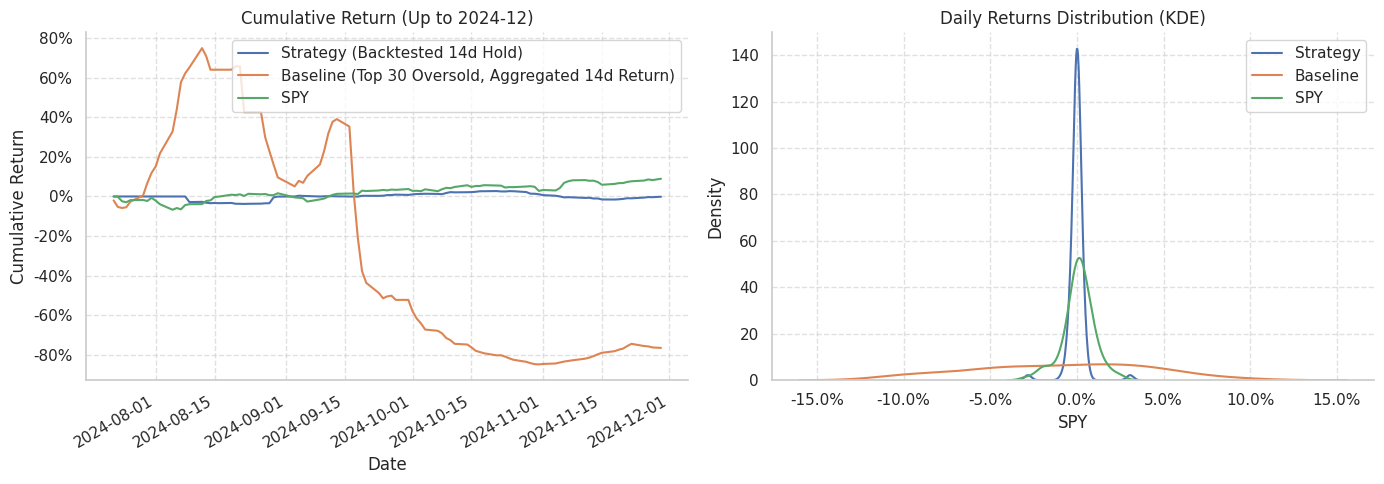

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import yfinance as yf
import ta


if 'test_df' in locals():
        if not pd.Index(original_indices).isin(test_df.index).all():
            print("Warning: Some original indices are not present in the original test_df.")
            valid_indices_mask = pd.Index(original_indices).isin(test_df.index)
            original_indices = original_indices[valid_indices_mask]
            preds = y_test_pred[valid_indices_mask]
            targs = y_test[valid_indices_mask]
            print(f"Filtered down to {len(original_indices)} valid indices.")

        eval_df_source = test_df.loc[original_indices].reset_index(drop=True)

        if len(y_test) == len(y_test_pred) == len(eval_df_source):
            eval_df = pd.DataFrame({
                'Date': eval_df_source['Date'].values,
                'Ticker': eval_df_source['Ticker'].values,
                'Close': eval_df_source['Close'].values,
                'y_true': y_test,
                'y_pred': y_test_pred,
                'rsi': eval_df_source['rsi'].values,
                'stochastic': eval_df_source['stochastic'].values,
                'return_14d': eval_df_source['return_14d'].values
            })
            eval_df['AbsError'] = np.abs(eval_df['y_true'] - eval_df['y_pred'])

if 'eval_df' not in locals() or 'Close' not in eval_df.columns or 'rsi' not in eval_df.columns or 'stochastic' not in eval_df.columns:
    print("Error: eval_df not found or missing required columns ('Close', 'rsi', 'stochastic'). Cannot perform backtest and baseline.")
else:
    eval_df['Date'] = pd.to_datetime(eval_df['Date'])
    eval_df = eval_df.sort_values(['Date', 'Ticker']).reset_index(drop=True)

    predictions_wide = eval_df.pivot(index='Date', columns='Ticker', values='y_pred')
    eval_df_wide = eval_df.pivot(index='Date', columns='Ticker', values='return_14d')
    close_prices_wide = eval_df.pivot(index='Date', columns='Ticker', values='Close')

    common_dates = predictions_wide.index.intersection(eval_df_wide.index).intersection(close_prices_wide.index)
    predictions_wide = predictions_wide.loc[common_dates].sort_index()
    eval_df_wide = eval_df_wide.loc[common_dates].sort_index()
    close_prices_wide = close_prices_wide.loc[common_dates].sort_index()


    assert eval_df_wide.index.equals(predictions_wide.index)
    assert eval_df_wide.index.equals(close_prices_wide.index)
    assert eval_df_wide.shape == predictions_wide.shape
    assert eval_df_wide.shape == close_prices_wide.shape

    N_LONG = 50
    N_SHORT = 50
    HOLDING_PERIOD = 14
    INITIAL_CAPITAL = 10000
    EQUITY_PER_POSITION = INITIAL_CAPITAL / (N_LONG + N_SHORT) if (N_LONG + N_SHORT) > 0 else 100


    print("\n--- Running Model Strategy Backtest ---")
    cash = INITIAL_CAPITAL
    portfolio_value = INITIAL_CAPITAL
    portfolio_history = pd.Series(index=eval_df_wide.index, dtype=float)
    if not eval_df_wide.index.empty:
        portfolio_history.iloc[0] = INITIAL_CAPITAL
    open_positions = {}
    daily_returns_proper = pd.Series(index=eval_df_wide.index, dtype=float)


    for current_idx in range(len(eval_df_wide.index)):
        current_date = eval_df_wide.index[current_idx]
        previous_portfolio_value = portfolio_value if current_idx > 0 else INITIAL_CAPITAL


        exited_tickers_today = []
        profit_loss_from_exits = 0
        capital_returned_from_exits = 0

        tickers_to_remove = []
        for ticker, pos_info in list(open_positions.items()):
             if current_idx >= pos_info['entry_idx'] + HOLDING_PERIOD:
                 exited_tickers_today.append(ticker)
                 profit_loss = pos_info['entry_value'] * pos_info['return_on_exit']
                 profit_loss_from_exits += profit_loss
                 capital_returned_from_exits += pos_info['entry_value']
                 tickers_to_remove.append(ticker)

        for ticker in tickers_to_remove:
             del open_positions[ticker]

        cash += capital_returned_from_exits + profit_loss_from_exits


        signaled_tickers_today = []
        if current_idx < len(predictions_wide):
            predictions_today = predictions_wide.iloc[current_idx]
            actual_returns_today_entry = eval_df_wide.iloc[current_idx]
            close_prices_today = close_prices_wide.iloc[current_idx]

            long_candidates = predictions_today.where(predictions_today > 0).dropna().rank(ascending=False)
            short_candidates = predictions_today.where(predictions_today < 0).dropna().rank(ascending=True)

            long_signals_today = long_candidates[long_candidates <= N_LONG].index.tolist()
            short_signals_today = short_candidates[short_candidates <= N_SHORT].index.tolist()

            signaled_tickers_today = list(set(long_signals_today + short_signals_today))
            signaled_tickers_today = [t for t in signaled_tickers_today if t not in open_positions]

            num_new_positions = len(signaled_tickers_today)
            capital_for_new_positions = num_new_positions * EQUITY_PER_POSITION

            cash -= capital_for_new_positions

            for ticker in signaled_tickers_today:
                return_on_exit = actual_returns_today_entry.get(ticker)
                entry_price = close_prices_today.get(ticker)

                if pd.notna(return_on_exit) and pd.notna(entry_price) and entry_price != 0:
                     open_positions[ticker] = {
                        'entry_idx': current_idx,
                        'entry_date': current_date,
                        'entry_value': EQUITY_PER_POSITION,
                        'return_on_exit': return_on_exit,
                        'entry_price': entry_price
                     }


        value_of_open_positions = sum(pos_info['entry_value'] for pos_info in open_positions.values())
        portfolio_value = cash + value_of_open_positions

        daily_return = (portfolio_value - previous_portfolio_value) / previous_portfolio_value if previous_portfolio_value != 0 else 0


        daily_returns_proper.loc[current_date] = daily_return
        portfolio_history.loc[current_date] = portfolio_value


    print(f"--- End of Backtest: Processing {len(open_positions)} remaining open positions ---")
    profit_loss_from_final_closeout = 0
    capital_returned_from_final_closeout = 0

    if not eval_df_wide.index.empty:
        last_idx = len(eval_df_wide.index) - 1
        last_date = eval_df_wide.index[last_idx]
        close_prices_last_day = close_prices_wide.iloc[last_idx]

        tickers_to_remove = []
        for ticker, pos_info in list(open_positions.items()):
             entry_price = pos_info['entry_price']
             last_price = close_prices_last_day.get(ticker)


             if pd.notna(entry_price) and entry_price != 0 and pd.notna(last_price):
                 actual_partial_return = (last_price / entry_price) - 1
                 profit_loss = pos_info['entry_value'] * actual_partial_return
                 profit_loss_from_final_closeout += profit_loss
                 capital_returned_from_final_closeout += pos_info['entry_value']

                 tickers_to_remove.append(ticker)


        cash += capital_returned_from_final_closeout + profit_loss_from_final_closeout
        final_portfolio_value = cash

        if not portfolio_history.empty:
           portfolio_history.iloc[-1] = final_portfolio_value

        if len(eval_df_wide.index) > 1:
             previous_to_last_portfolio_value = portfolio_history.iloc[-2]
             daily_return_last_day = (final_portfolio_value - previous_to_last_portfolio_value) / previous_to_last_portfolio_value if previous_to_last_portfolio_value != 0 else 0
             daily_returns_proper.iloc[-1] = daily_return_last_day
        elif len(eval_df_wide.index) == 1:
             daily_return_last_day = (final_portfolio_value - INITIAL_CAPITAL) / INITIAL_CAPITAL if INITIAL_CAPITAL != 0 else 0
             daily_returns_proper.iloc[-1] = daily_return_last_day

    print(f"Total Capital Returned from Final Closeout: {capital_returned_from_final_closeout:.2f}")
    print(f"Total Profit/Loss from Final Closeout: {profit_loss_from_final_closeout:.2f}")
    print(f"Final Portfolio Value after Closeout: {final_portfolio_value:.2f}")



    daily_returns_proper = daily_returns_proper.dropna().sort_index()
    portfolio_history = portfolio_history.dropna().sort_index()



    print("\n--- Running Baseline Strategy Calculation ---")

    df_baseline = eval_df.copy()

    if 'rsi' in df_baseline.columns and 'stochastic' in df_baseline.columns:
         df_baseline['oversold_score'] = (df_baseline['rsi'] + df_baseline['stochastic']) / 2.0


         baseline_buy_condition = (df_baseline['rsi'] < 30) & (df_baseline['stochastic'] < 20)


         df_baseline.loc[baseline_buy_condition, 'baseline_oversold_rank'] = df_baseline[baseline_buy_condition] \
             .groupby('Date')['oversold_score'] \
             .rank(method='first', ascending=True)

         N_BASELINE = 30
         df_baseline['baseline_signal'] = np.where(
             df_baseline['baseline_oversold_rank'] <= N_BASELINE, 1, 0
         )

         df_baseline['signaled_baseline_return'] = df_baseline['return_14d'] * df_baseline['baseline_signal']

         baseline_daily_returns = df_baseline.groupby('Date')['signaled_baseline_return'].sum() / \
                                  np.maximum(1, df_baseline.groupby('Date')['baseline_signal'].sum())

         baseline_daily_returns = baseline_daily_returns.where(df_baseline.groupby('Date')['baseline_signal'].sum() > 0, 0)

         baseline_daily_returns = baseline_daily_returns.reindex(daily_returns_proper.index).fillna(0)

         print(f"Baseline Strategy calculated for {len(baseline_daily_returns)} dates.")

    else:
        print("Warning: 'rsi' or 'stochastic' columns not found in eval_df. Skipping baseline calculation.")
        baseline_daily_returns = pd.Series(dtype=float)

    cut_off_date = pd.to_datetime('2024-12-01')
    portfolio_history_filtered = portfolio_history[portfolio_history.index < cut_off_date]
    daily_returns_proper_filtered = daily_returns_proper[daily_returns_proper.index < cut_off_date]

    baseline_daily_returns_filtered = baseline_daily_returns[baseline_daily_returns.index < cut_off_date]

    try:
        start_date = portfolio_history_filtered.index.min()
        end_date = portfolio_history_filtered.index.max()

        if hasattr(start_date, 'tzinfo') and start_date.tzinfo is not None:
            start_date = start_date.tz_convert(None)
        if hasattr(end_date, 'tzinfo') and end_date.tzinfo is not None:
             end_date = end_date.tz_convert(None)

        spy_ticker = 'SPY'

        print(f"\nDownloading benchmark data for plotting up to {end_date.strftime('%Y-%m-%d')}")
        spy_data = yf.download(spy_ticker, start=start_date, end=end_date + pd.Timedelta(days=1), interval="1d", auto_adjust=True, progress=True)

        if spy_data.empty:
            print(f"Warning: Could not download benchmark data for {spy_ticker} up to {end_date}. Using zero return benchmark.")
            benchmark_returns_to_plot_filtered = pd.Series(0, index=portfolio_history_filtered.index)
            benchmark_label = 'No Benchmark Data'
        else:
            if hasattr(spy_data.index, 'tzinfo') and spy_data.index.tzinfo is not None:
                 spy_data.index = spy_data.index.tz_convert(None)

            benchmark_returns_spy = spy_data['Close'].pct_change().fillna(0)
            benchmark_returns_to_plot_filtered = benchmark_returns_spy.reindex(portfolio_history_filtered.index).ffill().bfill().fillna(0)

            benchmark_label = f'{spy_ticker}'

    except Exception as e:
        print(f"An error occurred while downloading or processing benchmark data for plotting: {e}")
        benchmark_returns_to_plot_filtered = pd.Series(0, index=portfolio_history_filtered.index)
        benchmark_label = 'Benchmark Error'


    fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

    if not portfolio_history_filtered.empty:
        initial_filtered_value = portfolio_history_filtered.iloc[0]
        cumulative_percentage_return_filtered = (portfolio_history_filtered / initial_filtered_value) - 1.0
        cumulative_percentage_return_filtered.plot(ax=axes[0], label=f'Strategy (Backtested {HOLDING_PERIOD}d Hold)', lw=1.5)
    else:
        print("Filtered portfolio history is empty. Cannot plot strategy cumulative return.")

    if not baseline_daily_returns_filtered.empty:
         baseline_cumulative_filtered = baseline_daily_returns_filtered.add(1).cumprod().sub(1)
         baseline_cumulative_filtered.plot(ax=axes[0], label=f'Baseline (Top {N_BASELINE} Oversold, Aggregated 14d Return)', lw=1.5) # Add baseline plot
    else:
         print("Filtered baseline daily returns is empty. Cannot plot baseline cumulative return.")


    benchmark_cumulative_filtered = benchmark_returns_to_plot_filtered.add(1).cumprod().sub(1)
    benchmark_cumulative_filtered.plot(ax=axes[0], label=benchmark_label, lw=1.5)

    axes[0].set_title('Cumulative Return (Up to 2024-12)')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Cumulative Return')
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)

    clip_min_kde, clip_max_kde = -0.1, 0.1
    strategy_returns_finite_filtered = daily_returns_proper_filtered[np.isfinite(daily_returns_proper_filtered)]
    baseline_returns_finite_filtered = baseline_daily_returns_filtered[np.isfinite(baseline_daily_returns_filtered)]
    benchmark_returns_finite_filtered = benchmark_returns_to_plot_filtered[np.isfinite(benchmark_returns_to_plot_filtered)]

    if not strategy_returns_finite_filtered.empty:
        sns.kdeplot(strategy_returns_finite_filtered.clip(clip_min_kde, clip_max_kde), ax=axes[1], label='Strategy', lw=1.5)
    else:
        print("Warning: Filtered daily strategy returns are all non-finite or empty. Cannot plot strategy KDE.")

    if not baseline_returns_finite_filtered.empty:
         sns.kdeplot(baseline_returns_finite_filtered.clip(clip_min_kde, clip_max_kde), ax=axes[1], label='Baseline', lw=1.5)
    else:
         print("Warning: Filtered baseline daily returns are all non-finite or empty. Cannot plot baseline KDE.")


    if not benchmark_returns_finite_filtered.empty:
        if isinstance(benchmark_returns_finite_filtered, pd.DataFrame):
            benchmark_returns_finite_filtered = benchmark_returns_finite_filtered.iloc[:, 0]
        sns.kdeplot(benchmark_returns_finite_filtered.clip(clip_min_kde, clip_max_kde), ax=axes[1], label=benchmark_label, lw=1.5)
    else:
         print("Warning: Benchmark returns are all non-finite or empty. Cannot plot benchmark KDE.")

    axes[1].set_title('Daily Returns Distribution (KDE)')
    axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)

    sns.despine()
    fig.tight_layout()
    plt.show()